In [ ]:
pip install tensorboardX

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 kB 2.7 MB/s eta 0:00:00


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

# Define directory path
save_directory = '/content/drive/My Drive/MyModels/Resnet-18_hard/'

# Check if directory exists. If not, create it.
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

In [3]:
# Setup
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
# from tensorboardX import SummaryWriter
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [4]:
# Ensure reproducibility by setting seeds
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
np.random.seed(42)

In [5]:
# Set up TensorBoard logging
log_dir = './logs'
writer = SummaryWriter(log_dir)

%load_ext tensorboard
%tensorboard --logdir ./logs

NameError: ignored

In [6]:
# Load CIFAR-10 training data without any transformations
untransformed_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())

# Compute mean and standard deviation
channel_sum = torch.zeros(3)
channel_squared_sum = torch.zeros(3)
num_pixels = 0

for data, _ in untransformed_trainset:
    channel_sum += data.sum(dim=[1,2])
    channel_squared_sum += (data**2).sum(dim=[1,2])
    num_pixels += data.size(1) * data.size(2)

mean = channel_sum / num_pixels
std_dev = (channel_squared_sum/num_pixels - mean**2)**0.5

print("Computed Mean:", mean)
print("Computed Std Dev:", std_dev)

100%|██████████| 170498071/170498071 [00:01<00:00, 103345971.38it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Computed Mean: tensor([0.4914, 0.4822, 0.4465])
Computed Std Dev: tensor([0.2470, 0.2435, 0.2616])


In [7]:
# Training data transformations
train_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Pad(4),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.RandomCrop(32),
        transforms.Normalize(mean, std_dev)
    ]
)

# Validation data transformations
val_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean, std_dev)
    ]
)

# Test data transformations
test_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean, std_dev)
    ]
)

# First, load the full training data without any transformations
full_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())

# Apply transformations to the full dataset
full_trainset.transform = train_transform

# Get the indices for training and validation splits
num_train = len(full_trainset)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(0.9 * num_train))
train_idx, valid_idx = indices[:split], indices[split:]

# Define samplers for the training and validation sets
train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
valid_sampler = torch.utils.data.SubsetRandomSampler(valid_idx)

# Create data loaders using these samplers
trainloader = torch.utils.data.DataLoader(full_trainset, batch_size=300, sampler=train_sampler, num_workers=2)
valloader = torch.utils.data.DataLoader(full_trainset, batch_size=300, sampler=valid_sampler, num_workers=2)

# Loading and creating data loader for test set
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=300, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [8]:
# Device Setup
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Model Definition
class CIFAR10ResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super(CIFAR10ResNet18, self).__init__()
        self.resnet = models.resnet18(pretrained=False)
        self.resnet.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)

    def forward(self, x):
        return self.resnet(x)

model = CIFAR10ResNet18().to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
# Training Loop
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.2, verbose=True)
best_val_accuracy = 0.0

# Lists to store metrics for each epoch
train_losses = []
val_losses = []

print("Starting Training...\n")

# Early stopping parameters
patience = 10  # Number of epochs with no improvement to wait before stopping
epochs_no_improve = 0
best_val_loss = float('inf')

num_epochs = 100
for epoch in range(num_epochs):
    # Training Phase
    model.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(trainloader)
    writer.add_scalar('Loss/train', avg_train_loss, epoch)
    train_losses.append(avg_train_loss)


    # Validation Phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in valloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(valloader)
    val_accuracy = 100 * correct / total

    print(f"Epoch [{epoch + 1}/{num_epochs}] - Training Loss: {avg_train_loss:.4f} - Validation Loss: {avg_val_loss:.4f} - Validation Accuracy: {val_accuracy:.2f}%")
    writer.add_scalar('Loss/validation', avg_val_loss, epoch)
    writer.add_scalar('Accuracy/validation', val_accuracy, epoch)
    val_losses.append(avg_val_loss)

    # Update the scheduler based on the validation loss
    scheduler.step(avg_val_loss)

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        model_save_path = os.path.join(save_directory, 'retrain_resnet18.pth')
        torch.save(model.state_dict(), model_save_path)
        print(f"New best validation accuracy ({val_accuracy:.2f}%) achieved and model saved!")

    # Check for early stopping
    if avg_val_loss < best_val_loss:
        epochs_no_improve = 0
        best_val_loss = avg_val_loss
    else:
        epochs_no_improve += 1
        if epochs_no_improve == patience:
            print("Early stopping!")
            break


print("\nTraining Complete!\n")

# Close the writer when done
writer.close()

Starting Training...

Epoch [1/100] - Training Loss: 1.4798 - Validation Loss: 1.4867 - Validation Accuracy: 47.74%
New best validation accuracy (47.74%) achieved and model saved!
Epoch [2/100] - Training Loss: 1.1150 - Validation Loss: 1.2571 - Validation Accuracy: 57.18%
New best validation accuracy (57.18%) achieved and model saved!
Epoch [3/100] - Training Loss: 0.9551 - Validation Loss: 0.9197 - Validation Accuracy: 67.20%
New best validation accuracy (67.20%) achieved and model saved!
Epoch [4/100] - Training Loss: 0.8426 - Validation Loss: 0.8936 - Validation Accuracy: 67.90%
New best validation accuracy (67.90%) achieved and model saved!
Epoch [5/100] - Training Loss: 0.7594 - Validation Loss: 0.8620 - Validation Accuracy: 70.00%
New best validation accuracy (70.00%) achieved and model saved!
Epoch [6/100] - Training Loss: 0.7067 - Validation Loss: 0.7986 - Validation Accuracy: 71.92%
New best validation accuracy (71.92%) achieved and model saved!
Epoch [7/100] - Training Loss:

Text(0.5, 1.0, 'Training & Validation Loss')

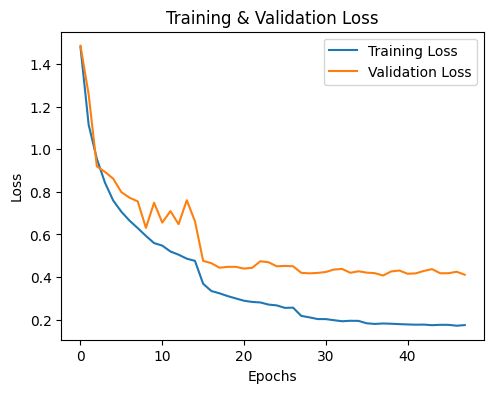

In [ ]:
# Plotting training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training & Validation Loss')

In [ ]:
# Load the best model weights
model_save_path = os.path.join(save_directory, 'retrain_resnet18.pth')
model.load_state_dict(torch.load(model_save_path))
model.to(device)


# Testing
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f"Accuracy of the model on the 10000 test images: {test_accuracy:.2f}%")

Accuracy of the model on the 10000 test images: 88.80%


In [9]:
# Load the best model weights
model_save_path = os.path.join(save_directory, 'retrain_resnet18.pth')
model.load_state_dict(torch.load(model_save_path))
model.to(device)

CIFAR10ResNet18(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tr

In [13]:
mean = torch.tensor([0.4914, 0.4822, 0.4465]).to(device)
std_dev = torch.tensor([0.2470, 0.2435, 0.2616]).to(device)

def fgsm_attack(image, epsilon, data_grad):
    """
    Generate adversarial example using Fast Gradient Sign Method.
    """
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image
    perturbed_image = image + epsilon * sign_data_grad
    # Clip the perturbed image to ensure values are in [0,1]
    for channel in range(3):
      perturbed_image[:, channel] = torch.clamp(perturbed_image[:, channel], (0-mean[channel]) / std_dev[channel], (1-mean[channel]) / std_dev[channel])

    return perturbed_image

def test_adversarial_robustness(model, testloader, device, epsilon_values=[0.01, 0.05, 0.1]):
    """
    Test the model's robustness against FGSM adversarial attack for a list of epsilon values.
    """
    accuracies = {}
    examples = []

    # Ensure model is in evaluation mode
    model.eval()

    for epsilon in epsilon_values:
        adv_correct = 0
        adv_examples = []

        for data, target in testloader:
            data, target = data.to(device), target.to(device)

            # Set requires_grad attribute of tensor for the attack
            data.requires_grad = True

            # Forward pass
            output = model(data)
            init_pred = output.max(1)[1]  # get the index of the max log-probability

            # Create a mask for data samples that were initially correctly classified
            correct_mask = init_pred == target

            # If no predictions in the batch are correct, continue to next batch
            if not correct_mask.any():
                continue

            # Calculate the loss only for correctly predicted samples
            loss = F.cross_entropy(output[correct_mask], target[correct_mask])

            # Zero all existing gradients
            model.zero_grad()

            # Calculate gradients of model in backward pass
            loss.backward()

            # Collect data gradient
            data_grad = data.grad.data

            # Call FGSM Attack only on correctly classified samples
            perturbed_data = fgsm_attack(data[correct_mask], epsilon, data_grad[correct_mask])

            # Re-classify the perturbed images
            output = model(perturbed_data)

            # Check for success
            final_pred = output.max(1)[1]
            adv_correct += (final_pred == target[correct_mask]).sum().item()

            # Save some adversarial examples for visualization later
            if len(adv_examples) < 5:
                for i, (perturbed_sample, orig_pred, true_target) in enumerate(zip(perturbed_data, init_pred[correct_mask], target[correct_mask])):
                    final_prediction = final_pred[i]
                    if orig_pred != final_prediction:
                        adv_ex = perturbed_sample.squeeze().detach().cpu().numpy()
                        adv_examples.append((orig_pred.item(), final_prediction.item(), adv_ex))

        # Calculate final accuracy for this epsilon
        adv_acc = adv_correct / float(len(testloader.dataset))
        print(f"Epsilon: {epsilon}\tTest Accuracy = {adv_correct} / {len(testloader.dataset)} = {adv_acc}")

        accuracies[epsilon] = adv_acc
        examples.append(adv_examples)

    return accuracies, examples


In [14]:
# Evaluate adversarial robustness
accuracies, examples = test_adversarial_robustness(model, testloader, device)

Epsilon: 0.01	Test Accuracy = 7109 / 10000 = 0.7109
Epsilon: 0.05	Test Accuracy = 1997 / 10000 = 0.1997
Epsilon: 0.1	Test Accuracy = 560 / 10000 = 0.056
